# 0-Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay, balanced_accuracy_score
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.optimizers import Adam
#from keras.backend import expand_dims
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.layers import Activation, Dense, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization, SpatialDropout1D

In [4]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# 1- Load Data

In [5]:
s_aureus = pd.read_csv('s_aureus_driams_a_bin3_2000_20000Da.csv')
s_aureus.head()

2000        2003        2006         2009         2012        2015  \
0  951.428571  826.125000  944.857143   898.428571  1007.714286  936.000000   
1  784.714286  701.125000  681.571429   762.142857   737.571429  733.000000   
2   50.875000   89.142857   56.142857   151.285714   132.714286  110.428571   
3  843.285714  816.500000  734.428571  1027.142857   979.428571  875.571429   
4  307.857143  295.000000  246.714286   181.571429   258.000000  318.714286   

         2018        2021        2024        2027  ...  19991  19994  \
0  828.571429  812.000000  782.714286  741.625000  ...   35.5   20.5   
1  735.857143  659.571429  802.714286  554.375000  ...   30.0   40.5   
2   47.285714   63.428571  100.375000   52.142857  ...    2.5   30.5   
3  912.142857  714.428571  945.428571  886.500000  ...   15.5    8.0   
4  295.714286  300.857143  278.142857  256.125000  ...   25.5   32.0   

       19997                                  code                species  \
0  27.342857  029f0abf-1664-424f-88cb-11c9c8af2b11  Staphylococcus aureus   
1  34.695238  08149af1-10f5-4f02-81d8-3d46d66d4a7a  Staphylococcus aureus   
2  11.288462  08fe3876-ecee-4ddc-9aa9-a84f605757f7  Staphylococcus aureus   
3  20.057143  0a9fdd4b-7180-47c0-849e-cb32d46da94c  Staphylococcus aureus   
4  24.990476  0d82f4c4-473c-49d8-8c85-e3e36e96d047  Staphylococcus aureus   

   Oxacillin  Clindamycin  Ceftriaxone  Ciprofloxacin  Fusidic acid  
0        0.0          0.0          0.0            0.0           1.0  
1        0.0          0.0          0.0            0.0           0.0  
2        0.0          0.0          0.0            0.0           0.0  
3        0.0          0.0          0.0            0.0           0.0  
4        1.0          0.0          1.0            1.0           0.0  

[5 rows x 6007 columns]

# Preprocessing Data

In [6]:
s_aureus_oxacillin = s_aureus.drop(columns=['code','species', 'Clindamycin', 'Ceftriaxone', 'Ciprofloxacin', 'Fusidic acid'])
s_aureus_oxacillin.dropna(axis=0, how="any", inplace=True)

In [7]:
s_aureus_ceftriaxone = s_aureus.drop(columns=['Oxacillin', 'Clindamycin', 'Ceftriaxone', 'Fusidic acid'])
#ceftriaxone.dropna(axis=0, how="any", inplace=True)
s_aureus_ceftriaxone.dropna(axis=0, how="any", inplace=True)
s_aureus_ceftriaxone.shape

(3757, 6003)

In [8]:
s_aureus_oxacillin.sample(2)

2000        2003        2006        2009        2012        2015  \
1073  198.857143  280.285714  206.428571  160.571429  170.571429  301.857143   
450   756.714286  796.875000  689.285714  581.428571  705.142857  806.000000   

            2018        2021        2024        2027  ...  19973  19976  \
1073  229.375000  204.714286  181.571429  208.571429  ...   53.5   73.5   
450   695.285714  591.285714  605.714286  713.500000  ...   16.0   16.5   

          19979      19982  19985  19988  19991      19994      19997  \
1073  46.666667  49.000000   29.5   34.0   38.0  55.000000  48.902913   
450   25.000000  21.666667   38.0   32.5   30.0  47.333333  31.971154   

      Oxacillin  
1073        0.0  
450         1.0  

[2 rows x 6001 columns]

In [9]:
print('clase minoritaria',s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 1].shape[0])
print('clase mayoritaria',s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 0].shape[0])

clase minoritaria 726
clase mayoritaria 3064


## Enfoque en clase minoritaria

In [16]:
minority_class = s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 1].drop(columns=['Oxacillin'])


In [17]:
minority_class

2000         2003         2006         2009         2012  \
4      307.857143   295.000000   246.714286   181.571429   258.000000   
10     233.142857   282.500000   276.142857   216.428571   198.000000   
15     539.571429   631.250000   579.000000   482.857143   673.571429   
20     808.571429   957.625000   807.285714   656.857143   747.714286   
24     694.285714   700.750000   525.571429   691.285714   687.857143   
...           ...          ...          ...          ...          ...   
3758   348.000000   417.285714   323.142857   357.142857   359.428571   
3765   440.600000   459.857143   337.714286   331.857143   375.571429   
3766   554.714286   591.142857   518.625000   518.714286   457.571429   
3769   206.571429   192.571429   192.571429   226.000000   194.125000   
3776  1204.714286  1348.428571  1212.375000  1199.142857  1091.428571   

             2015         2018         2021         2024         2027  ...  \
4      318.714286   295.714286   300.857143   278.142857   256.125000  ...   
10     255.000000   225.571429   228.571429   190.142857   241.375000  ...   
15     644.714286   527.714286   544.142857   514.428571   525.000000  ...   
20     801.571429   805.857143   727.857143   712.571429   675.625000  ...   
24     693.714286   596.142857   614.714286   453.571429   530.000000  ...   
...           ...          ...          ...          ...          ...  ...   
3758   365.571429   360.875000   340.285714   331.857143   334.142857  ...   
3765   343.750000   395.857143   324.142857   313.571429   336.571429  ...   
3766   511.571429   492.428571   540.571429   544.000000   574.375000  ...   
3769   222.428571   252.714286   216.428571   190.857143   189.571429  ...   
3776  1246.285714  1307.857143  1213.285714  1155.142857  1034.250000  ...   

      19970      19973  19976  19979  19982      19985  19988  19991  19994  \
4      16.5  26.666667   25.5   18.0   53.5  23.000000   24.5   25.5   32.0   
10     14.0  14.333333   18.0   25.5    4.5  32.333333   21.5   18.0   31.5   
15     60.0  16.666667   26.5   29.5   26.0   7.333333   18.0   17.0   30.0   
20     25.5  27.333333   31.0   59.5   16.5  28.333333   81.0   34.5   36.5   
24      8.5  16.000000   24.5   24.5   25.5   3.333333    5.0   13.5   23.5   
...     ...        ...    ...    ...    ...        ...    ...    ...    ...   
3758   21.5  26.666667   21.0   22.0   20.5  30.666667   14.5   22.5   26.0   
3765    0.0   0.000000    0.0    0.0    0.0   0.000000    0.0    0.0    0.0   
3766    0.0   0.000000    0.0    0.0    0.0   0.000000    0.0    0.0    0.0   
3769    3.5   1.666667    5.5    4.0    4.0   1.000000    4.5    2.0    1.5   
3776    0.0   0.000000    0.0    0.0    0.0   0.000000    0.0    0.0    0.0   

          19997  
4     24.990476  
10    16.295238  
15    23.180952  
20    30.161905  
24    20.771429  
...         ...  
3758  24.800000  
3765   0.000000  
3766   0.024259  
3769   2.000000  
3776   0.123822  

[726 rows x 6000 columns]

## Copulas

In [18]:
import copulas

print(copulas.__version__)

0.12.0


In [19]:
from copulas.multivariate import GaussianMultivariate

copula = GaussianMultivariate()

In [20]:
copula.fit(minority_class)

/usr/local/lib/python3.9/dist-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.9/dist-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.9/dist-packages/scipy/stats/_continuous_distns.py:5574: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/usr/local/lib/python3.9/dist-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in scalar multiply
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.9/dist-packages/scipy/stats/_continuous_distns.py:5574: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/usr/local/lib/python3.9/dist-packages/scipy/stats/_distn_infrastructure.py:2789: R

In [ ]:
print('clase minoritaria',s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 1].shape[0])
print('clase mayoritaria',s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 0].shape[0])

In [21]:
synthetic_data = copula.sample(num_rows=s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 0].shape[0]-s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 1].shape[0])
synthetic_data.head()

2000         2003          2006          2009         2012  \
0  1731.552073  2282.367239   1801.197302   1545.891740  1652.071987   
1   719.226134   696.523511    626.315898    713.227658  1134.862392   
2  9448.106548  9528.737744  10973.191723  12058.101966  9153.210646   
3  1435.914498  1522.514877   1501.225548   1166.442471  1496.337282   
4  3322.739004  2659.330755   2933.828109   3828.755360  3487.885744   

           2015          2018         2021          2024          2027  ...  \
0   1812.093016   2086.857775  1632.440665   1632.530942   1428.735764  ...   
1    903.706388    788.148851   662.279020    708.606012    726.044469  ...   
2  12325.599157  12003.315560  8386.845748  13440.111235  10297.580912  ...   
3   1360.658119   1518.168811  1502.347483   1338.495070   1513.258450  ...   
4   3745.869059   3006.654803  2863.128315   2492.930703   2378.347212  ...   

       19970       19973      19976      19979      19982      19985  \
0 -13.759674    0.421017   0.597127 -11.826443   0.394260   0.488425   
1   9.519646   41.978777  62.572333   4.947150  60.391061  51.689979   
2 -13.303723    0.492091   0.522824 -14.411760   0.724772   0.521107   
3  43.078235   29.248265  21.111759  22.351198  41.639472  28.699735   
4  55.062972  105.193532  56.938249  56.176511  71.818195  55.681015   

       19988      19991      19994      19997  
0   0.850972   0.594676   0.521149   0.045756  
1  64.164551  89.969335  47.641117  33.581701  
2   0.475111   0.345871   0.417645   0.008799  
3  17.644145  28.850859  11.498240  20.169753  
4  72.565281  81.220327  67.599309  57.960530  

[5 rows x 6000 columns]

In [20]:
synthetic_data.shape

(2338, 6000)

In [22]:
combined_data = pd.concat([synthetic_data, s_aureus_oxacillin], ignore_index=True)


In [23]:
combined_data = combined_data.fillna(1)

In [24]:
s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 0].shape

(3064, 6001)

In [25]:
combined_data.shape

(6128, 6001)

In [26]:
X = combined_data.iloc[:, 0:6000].values  # variables independientes (espectros de masa)
y = combined_data.iloc[:, 6000].values    # variable dependientes (resistencia a ciprofloxacin)
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

In [28]:
print(pd.Series(y_train).value_counts())


0.0    2451
1.0    2451
Name: count, dtype: int64


In [29]:
scaler=Normalizer(norm='max')
sc_X = scaler
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [30]:
sample_size = X_train.shape[0] # numero de muestras en el set de datos
time_steps  = X_train.shape[1] # numero de atributos en el set de datos
input_dimension = 1            #

X_train_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [31]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001)
early_st = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

n_timesteps = X_train_reshaped.shape[1] #
n_features  = X_train_reshaped.shape[2] #

# Create and fit DeepAMR model

In [32]:
model = Sequential(name="Modelo_s_aureus_ciprofloxacin")
init_mode = 'normal'
model.add(Conv1D(filters=(64), kernel_size=(17), input_shape = (n_timesteps,n_features), name='Conv_1'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_1"))

model.add(Conv1D(filters=(128), kernel_size=(9),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name='Conv_2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_2"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode,kernel_regularizer=regularizers.l2(0.0001),   name='Conv_3'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_3"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),   name='Conv_4'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_4"))

model.add(Flatten())
model.add(Dropout(0.65))
model.add(Dense(256, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_0"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_1"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name="fully_connected_2"))
model.add(Dense(n_features, activation='sigmoid', name="OUT_Layer"))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy',  metrics=METRICS)
model.summary()

Model: "Modelo_s_aureus_ciprofloxacin"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv1D)             (None, 5984, 64)          1152      
                                                                 
 batch_normalization (BatchN  (None, 5984, 64)         256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 5984, 64)          0         
                                                                 
 MaxPooling1D_1 (MaxPooling1  (None, 2992, 64)         0         
 D)                                                              
                                                                 
 Conv_2 (Conv1D)             (None, 2984, 128)         73856     
                                                                 
 batch_normalization_1 (Batc  (None, 

In [33]:
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=10, verbose=1, validation_split=0.1, callbacks=[reduce_lr,early_st])

Epoch 1/100


2024-12-25 11:53:01.012873: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8907
2024-12-25 11:53:01.088063: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-25 11:53:02.440846: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


442/442 [==============================] - 16s 27ms/step - loss: 6.2755 - tp: 1478.0000 - fp: 714.0000 - tn: 1498.0000 - fn: 721.0000 - accuracy: 0.6747 - precision: 0.6743 - recall: 0.6721 - auc: 0.7413 - prc: 0.7395 - val_loss: 5.8522 - val_tp: 227.0000 - val_fp: 120.0000 - val_tn: 119.0000 - val_fn: 25.0000 - val_accuracy: 0.7047 - val_precision: 0.6542 - val_recall: 0.9008 - val_auc: 0.8339 - val_prc: 0.8521 - lr: 1.0000e-04
Epoch 2/100
442/442 [==============================] - 12s 27ms/step - loss: 5.4107 - tp: 1719.0000 - fp: 479.0000 - tn: 1733.0000 - fn: 480.0000 - accuracy: 0.7826 - precision: 0.7821 - recall: 0.7817 - auc: 0.8664 - prc: 0.8750 - val_loss: 5.0289 - val_tp: 231.0000 - val_fp: 55.0000 - val_tn: 184.0000 - val_fn: 21.0000 - val_accuracy: 0.8452 - val_precision: 0.8077 - val_recall: 0.9167 - val_auc: 0.9413 - val_prc: 0.9540 - lr: 1.0000e-04
Epoch 3/100
442/442 [==============================] - 12s 27ms/step - loss: 4.8098 - tp: 1824.0000 - fp: 273.0000 - tn: 19

# Evaluate the model

In [34]:
y_pred  = model.predict(X_test_reshaped)
y_pred = (y_pred>0.5)
cm = confusion_matrix(y_test, y_pred)
print(cm)

39/39 [==============================] - 1s 9ms/step
[[600  13]
 [ 58 555]]


In [35]:
print("balanced acuracy:", balanced_accuracy_score(y_test, y_pred))

balanced acuracy: 0.9420880913539967


In [36]:
target_names=["0","1"]
print(classification_report(y_test, y_pred, target_names=target_names))

train_predictions_baseline = model.predict(X_train_reshaped, batch_size=10)
test_predictions_baseline = model.predict(X_test_reshaped, batch_size=10)

baseline_results = model.evaluate(X_test_reshaped, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       613
           1       0.98      0.91      0.94       613

    accuracy                           0.94      1226
   macro avg       0.94      0.94      0.94      1226
weighted avg       0.94      0.94      0.94      1226

123/123 [==============================] - 1s 5ms/step
loss :  0.47884565591812134
tp :  555.0
fp :  13.0
tn :  600.0
fn :  58.0
accuracy :  0.9420880675315857
precision :  0.9771126508712769
recall :  0.9053833484649658
auc :  0.9849429130554199
prc :  0.9868772625923157



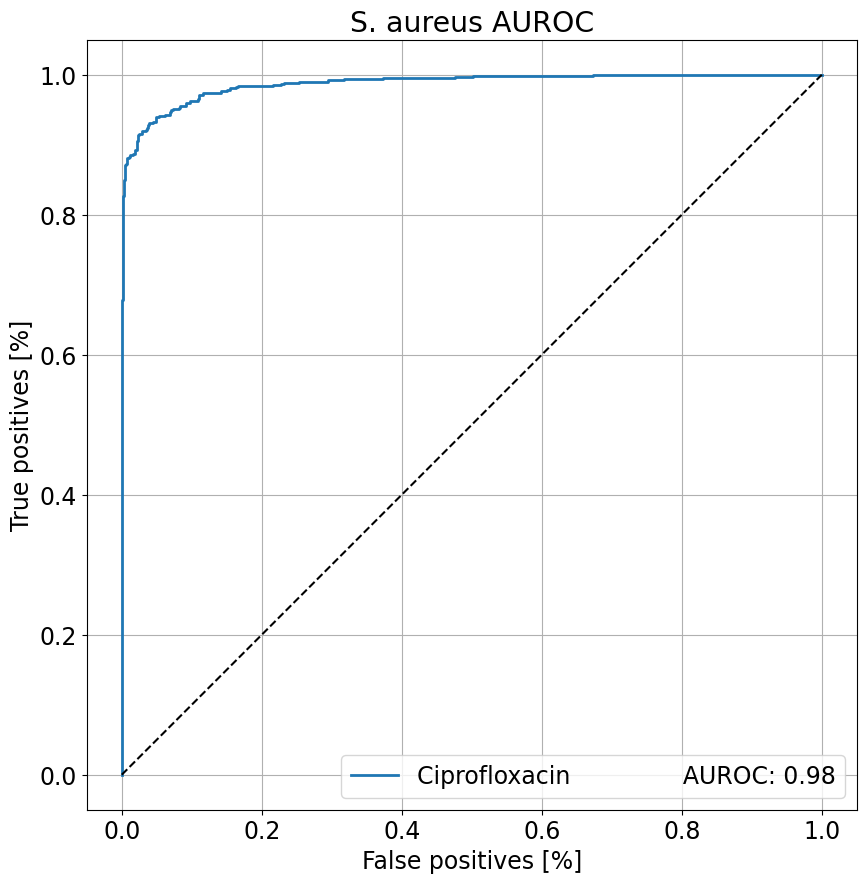

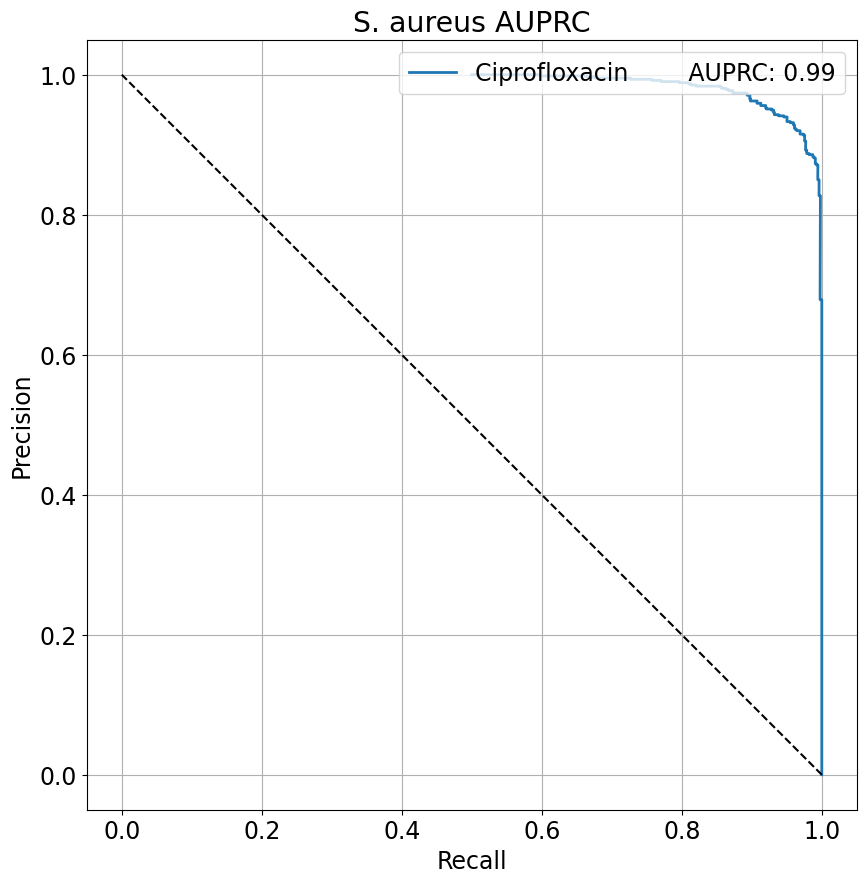

In [37]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams.update({'font.size': 17})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.title('E. coli CNN')
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.title('S. aureus AUROC')

  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
plot_roc("Ciprofloxacin               AUROC: %0.2f" % baseline_results[8], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='lower right')
plt.savefig('s_aureus_auroc.png', bbox_inches='tight')
plt.show()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.title('S. aureus AUPRC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot([1, 0], [0, 1], 'k--')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Ciprofloxacin        AUPRC: %0.2f" % baseline_results[9], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='upper right')
plt.savefig('s_aureus_auprc.png', bbox_inches='tight')
plt.show()